# Defining MLP

In [1]:
import os
os.chdir('/Users/mikolajmroz/Developer/Computational_Intelligence_Methods')
print(os.getcwd())

/Users/mikolajmroz/Developer/Computational_Intelligence_Methods


In [4]:
# import os
# os.chdir('c:\\Users\\mikol\\Documents\\Computational_Intelligence_Methods\\Computational_Intelligence_Methods')
# print(os.getcwd())

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [6]:
def sigmoid(x):
    x = np.clip(x, -500, 500)  # Avoid overflow
    return np.where(x > 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

In [7]:
def sigmoid_derivative(x):
    # Corrected sigmoid derivative to properly compute the derivative
    return sigmoid(x) * (1 - sigmoid(x))

In [8]:
def linear(x):
    """Linear activation function: f(x) = x"""
    return x

In [9]:
def linear_derivative(x):
    """Derivative of linear activation function: f'(x) = 1"""
    return 1

In [10]:
def relu(x):
    """ReLU activation function: f(x) = max(0, x)"""
    return np.maximum(0,x)

In [11]:
def relu_derivative(x):
    """Derivative of ReLU activation function: f'(x) = 1 if x > 0 else 0"""
    return np.where(x > 0, 1, 0)

In [12]:
def tanh(x):
    """Tanh activation function: f(x) = tanh(x)"""
    return np.tanh(x)

In [13]:
def tanh_derivative(x):
    """Derivative of tanh activation function: f'(x) = 1 - tanh(x)^2"""
    return 1 - np.tanh(x)**2

In [14]:
def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

In [15]:
class MLP:
    
    def __init__(self, layer_sizes, activation_function=sigmoid, activation_function_derivative=sigmoid_derivative):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.randn(y, x) * np.sqrt(1.0 / x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]
        self.velocity = [np.zeros_like(w) for w in self.weights]
        self.cache = [np.zeros_like(w) for w in self.weights]
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative

        print(self.weights)

    def print_final_weights_and_biases(self):
        print("Final Weights and Biases:")
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            print(f"Layer {i + 1} Weights:\n{w}")
            print(f"Layer {i + 1} Biases:\n{b}")

    def feedforward(self, a):
        activations = [a]  # Stores all activations
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            a = self.activation_function(np.dot(w, a)+ b) 
            activations.append(a)
        # Linear activation for the last layer
        a = np.dot(self.weights[-1], a) + self.biases[-1]
        activations.append(a)
        return activations[-1], activations  # Return final activation and all activations

    def backprop(self, x, y):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        final_output, activations = self.feedforward(x)
        zs = [np.dot(w, act) + b for w, b, act in zip(self.weights, self.biases, activations[:-1])]  # Z values

        # Output layer error
        delta = self.cost_derivative(final_output, y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        # Backpropagate the error
        for l in range(2, len(self.layer_sizes)):
            sp = self.activation_function_derivative(zs[-l])
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].T)

        return nabla_w, nabla_b

    def update_mini_batch(self, mini_batch, learning_rate, lambda_, n, optimization_method='sgd', beta=0.9, epsilon=1e-8):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        for x, y in mini_batch:
            delta_nabla_w, delta_nabla_b = self.backprop(x, y)
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]

        if optimization_method == 'sgd':
            self.weights = [(1 - learning_rate * (lambda_ / n)) * w - (learning_rate / len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
            self.biases = [b - (learning_rate / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]
        elif optimization_method == 'momentum':
            self.velocity = [beta * v + (1 - beta) * nw for v, nw in zip(self.velocity, nabla_w)]
            self.weights = [w - (learning_rate / len(mini_batch)) * v for w, v in zip(self.weights, self.velocity)]
            self.biases = [b - (learning_rate / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]
        elif optimization_method == 'rmsprop':
            self.cache = [beta * c + (1 - beta) * (nw**2) for c, nw in zip(self.cache, nabla_w)]
            self.weights = [w - (learning_rate / (np.sqrt(c) + epsilon)) * nw for w, c, nw in zip(self.weights, self.cache, nabla_w)]
            self.biases = [b - (learning_rate / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]
        else:
            raise ValueError("Unsupported optimization method")

    def train(self, training_data, epochs, learning_rate, batch_size, lambda_=0.0, update_method = 'batch', optimization_method='sgd', beta=0.9, epsilon=1e-8, plot_interval=None, visual_interval=100, mse_limit=None, X_val_scaled=None, y_val_scaled=None, X_val=None, y_val=None, scaler_X=None, scaler_y=None):
    
        mse_history = []
        n = len(training_data)
        learning_rate_init = learning_rate

        for j in range(epochs):
            # Plot weights at the specified interval
            if plot_interval and j % plot_interval == 0:
                print(f"Epoch {j}:")
                self.plot_weights()

            np.random.shuffle(training_data)

            # Determine actual batch size
            actual_batch_size = int(batch_size * n) if isinstance(batch_size, float) else batch_size

            if update_method == 'batch':
                mini_batches = [training_data[k:k + actual_batch_size] for k in range(0, n, actual_batch_size)]
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, learning_rate, lambda_, n, optimization_method, beta, epsilon)
            elif update_method == 'epoch':
                self.update_mini_batch(training_data, learning_rate, lambda_, n, optimization_method, beta, epsilon)
            # Learning rate schedule
            # learning_rate = learning_rate_init / (1 + 0.01 * j)
            
            if j % visual_interval == 0 or j == epochs - 1:
                # Generate predictions for the validation set
                predictions_scaled_mse = np.array(
                    [self.feedforward(x.reshape(-1, 1))[0] for x in X_val_scaled])

                # Inverse transform the scaled predictions back to their original scale
                predictions_mse = scaler_y.inverse_transform(predictions_scaled_mse.reshape(-1, 1))

                # Calculate the mean squared error on the validation set
                current_mse = mse(predictions_mse, y_val)
                # Append the MSE to the history for tracking
                mse_history.append((j, current_mse))
                # Print the current epoch and its MSE
                print(f'Epoch {j}, MSE: {current_mse}')

                # If a threshold for MSE is set and the current MSE is below this threshold, stop training
                if mse_limit is not None and current_mse < mse_limit:
                    break

        # Return the history of MSE values
        return mse_history


    def cost_derivative(self, output_activations, y):
        return (output_activations - y)
    
    
    def visualize_network_working(self):
        fig, ax = plt.subplots()

        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))

            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)

        plt.show()
        
    def visualize_network(self):
        fig, ax = plt.subplots()
    
        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))
    
            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)
                        # Add weight value on the line
                        ax.text(i + 0.5, (j + k) / 2, f'{weight:.2f}', color=color, ha='center')
    
            
    
        plt.show()

In [16]:
class DataScaler:
    def __init__(self, method="standardization"):
        self.method = method
        self.min = None
        self.max = None
        self.mean = None
        self.std = None

    def fit_transform(self, data):
        if self.method == "min_max":
            return self.fit_transform_min_max(data)
        elif self.method == "standardization":
            return self.fit_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def transform(self, data):
        if self.method == "min_max":
            return self.transform_min_max(data)
        elif self.method == "standardization":
            return self.transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def inverse_transform(self, data):
        if self.method == "min_max":
            return self.inverse_transform_min_max(data)
        elif self.method == "standardization":
            return self.inverse_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def fit_transform_min_max(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform_min_max(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform_min_max(self, data):
        return data * (self.max - self.min) + self.min

    def fit_transform_standardization(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return (data - self.mean) / self.std

    def transform_standardization(self, data):
        return (data - self.mean) / self.std

    def inverse_transform_standardization(self, data):
        return data * self.std + self.mean

In [17]:
def plot_mse(mse_history):
    plt.plot(mse_history)
    plt.title('MSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.show()

# Loading data

In [18]:
df_train_square_large = pd.read_csv('./data/regression/square-large-training.csv')
df_test_square_large = pd.read_csv('./data/regression/square-large-test.csv')

In [19]:
df_train_steps_large = pd.read_csv('./data/regression/steps-large-training.csv')
df_test_steps_large = pd.read_csv('./data/regression/steps-large-test.csv')

In [20]:
df_train_multimodal_large = pd.read_csv('./data/regression/multimodal-large-training.csv')
df_test_multimodal_large = pd.read_csv('./data/regression/multimodal-large-test.csv')

In [21]:
X_train_square_large = df_train_square_large['x'].values.reshape(-1, 1)
y_train_square_large = df_train_square_large['y'].values.reshape(-1, 1)

In [22]:
X_test_square_large = df_test_square_large['x'].values.reshape(-1, 1)
y_test_square_large = df_test_square_large['y'].values.reshape(-1, 1)

In [23]:
X_train_steps_large = df_train_steps_large['x'].values.reshape(-1, 1)
y_train_steps_large = df_train_steps_large['y'].values.reshape(-1, 1)

In [24]:
X_test_steps_large = df_test_steps_large['x'].values.reshape(-1, 1)
y_test_steps_large = df_test_steps_large['y'].values.reshape(-1, 1)

In [25]:
X_train_multimodal_large = df_train_multimodal_large['x'].values.reshape(-1, 1)
y_train_multimodal_large = df_train_multimodal_large['y'].values.reshape(-1, 1)

In [26]:
X_test_multimodal_large = df_test_multimodal_large['x'].values.reshape(-1, 1)
y_test_multimodal_large = df_test_multimodal_large['y'].values.reshape(-1, 1)

### multimodal-large dataset

In [27]:
# Initialize the scaler for X and y with the desired scaling method
scaler_X = DataScaler(method="standardization")
scaler_y = DataScaler(method="standardization")

In [28]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_multimodal_large)
y_train_scaled = scaler_y.fit_transform(y_train_multimodal_large)


In [29]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_multimodal_large)
y_test_scaled = scaler_y.transform(y_test_multimodal_large)

In [30]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_multimodal_large, y_train_multimodal_large)]

## 3 warstwy ukryte

In [123]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] )

[array([[ 1.33949519],
       [ 0.4392375 ],
       [-3.58942511],
       [-0.9969535 ],
       [ 0.65708854],
       [-0.26690666],
       [-1.24024053],
       [ 0.35944384],
       [-1.34108748],
       [ 0.62815056],
       [ 0.90888227],
       [ 0.28753358],
       [-0.06189827],
       [-0.26830811],
       [ 0.17121082],
       [ 1.09111152],
       [ 0.7518153 ],
       [ 0.37265455],
       [ 0.75643837],
       [ 1.04419777],
       [-0.01595158],
       [ 0.47251141],
       [-0.41809922],
       [-0.3650972 ],
       [ 1.36728626],
       [-0.76968181],
       [-1.10809372],
       [ 1.5243659 ],
       [ 0.53550284],
       [ 0.51764377],
       [ 0.04482505],
       [ 1.72810144],
       [ 0.73450222],
       [ 0.23284362],
       [ 0.35212935],
       [-0.64933653],
       [ 0.64573504],
       [ 1.622907  ],
       [-1.12403055],
       [-0.42416123],
       [ 0.4101852 ],
       [ 0.73035167],
       [-0.92408259],
       [ 1.50339859],
       [-0.48841322],
       [ 

In [124]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [144]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] , activation_function=sigmoid, activation_function_derivative= sigmoid_derivative)

[array([[ 1.74096067],
       [ 2.1370856 ],
       [-0.55710611],
       [ 0.95215592],
       [ 1.47546427],
       [ 0.4844807 ],
       [-0.54812152],
       [ 0.10189913],
       [-0.08269637],
       [ 0.03516863],
       [ 0.94185157],
       [-1.09474849],
       [ 1.67161272],
       [ 1.27771427],
       [-0.18295103],
       [-0.43740265],
       [ 0.27674921],
       [ 0.81487946],
       [-0.98784018],
       [ 1.30033822],
       [ 0.11158232],
       [-0.87414327],
       [-0.92637137],
       [ 1.21377665],
       [-0.20476764],
       [ 0.23781769],
       [ 0.63542728],
       [ 1.32314902],
       [ 1.06806463],
       [-0.02464292],
       [ 0.99038225],
       [ 1.20904521],
       [ 1.17266081],
       [ 0.2075306 ],
       [-0.15794682],
       [-0.4917527 ],
       [ 0.90192677],
       [ 0.58812344],
       [-0.17930139],
       [-1.76684466],
       [ 1.5076774 ],
       [ 0.4413053 ],
       [ 0.30807067],
       [ 1.31361725],
       [-0.6736753 ],
       [-

In [145]:
mse_sigmoid = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 697.7481038488936
Epoch 10, MSE: 61.309518407737926
Epoch 20, MSE: 25.497163571241806
Epoch 30, MSE: 15.532351947670907
Epoch 40, MSE: 6.6145408144789
Epoch 50, MSE: 15.794289466488873
Epoch 60, MSE: 8.622097024404361
Epoch 70, MSE: 17.545106821911816
Epoch 80, MSE: 27.718427440273814
Epoch 90, MSE: 7.37664819266604
Epoch 100, MSE: 15.95182817572536
Epoch 110, MSE: 30.68650054528282
Epoch 120, MSE: 4.92099178484128
Epoch 130, MSE: 4.144967526293931
Epoch 140, MSE: 5.449866610354083
Epoch 150, MSE: 4.8633740370762615
Epoch 160, MSE: 8.542719383018545
Epoch 170, MSE: 12.24504787049301
Epoch 180, MSE: 12.793744726329725
Epoch 190, MSE: 4.92076583297758
Epoch 200, MSE: 2.1743755014128276
Epoch 210, MSE: 7.389668402296304
Epoch 220, MSE: 2.3846634024288766
Epoch 230, MSE: 2.139153740850264
Epoch 240, MSE: 3.983708678300224
Epoch 250, MSE: 2.220061347214457
Epoch 260, MSE: 3.5581546577088066
Epoch 270, MSE: 2.089559202354919
Epoch 280, MSE: 5.941532384090058
Epoch 290, MSE: 2.2

In [146]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] , activation_function=linear, activation_function_derivative= linear_derivative)

[array([[ 0.3629092 ],
       [-1.33875728],
       [ 0.41958749],
       [-0.68845533],
       [ 0.25246338],
       [-0.01620371],
       [-0.37434497],
       [-0.07259988],
       [ 0.68535319],
       [ 1.5333149 ],
       [-1.03801013],
       [ 0.76104967],
       [-1.33988252],
       [-0.30254788],
       [ 2.17760351],
       [-1.4338981 ],
       [ 0.78215572],
       [ 0.20859995],
       [ 0.29074072],
       [ 1.55514626],
       [-0.3281972 ],
       [ 0.39288461],
       [ 1.1020287 ],
       [ 0.4636441 ],
       [ 0.1205712 ],
       [-1.23980507],
       [ 0.1385666 ],
       [ 0.59419127],
       [ 1.89613043],
       [ 0.17744486],
       [ 0.32682752],
       [ 0.09522017],
       [-0.66996187],
       [ 0.7613156 ],
       [-0.87393708],
       [-0.02246945],
       [-1.03196116],
       [ 0.68639969],
       [-0.63046879],
       [-2.28521666],
       [ 0.04653972],
       [-0.02012587],
       [ 0.20785288],
       [ 1.4406471 ],
       [-1.36011329],
       [-

In [147]:
mse_linear = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 4505.456174450471
Epoch 10, MSE: 4456.907747418768
Epoch 20, MSE: 4727.752045117667
Epoch 30, MSE: 4575.408478532733
Epoch 40, MSE: 4436.495206698132
Epoch 50, MSE: 5609.811577651828
Epoch 60, MSE: 4476.238804616722
Epoch 70, MSE: 4482.540420734381
Epoch 80, MSE: 4508.145200318277
Epoch 90, MSE: 9413.071003796867
Epoch 100, MSE: 4586.186854590115
Epoch 110, MSE: 4464.355359266975
Epoch 120, MSE: 4444.612536897266
Epoch 130, MSE: 4440.505301949108
Epoch 140, MSE: 4717.658620198319
Epoch 150, MSE: 4443.568311785323
Epoch 160, MSE: 4684.71534304488
Epoch 170, MSE: 4452.114305076105
Epoch 180, MSE: 4454.141668987131
Epoch 190, MSE: 4445.2813388878185
Epoch 200, MSE: 4448.788975317899
Epoch 210, MSE: 4456.618077032263
Epoch 220, MSE: 4439.820111901949
Epoch 230, MSE: 4455.695932053913
Epoch 240, MSE: 4462.284534144784
Epoch 250, MSE: 4476.2359775708965
Epoch 260, MSE: 4437.547504045376
Epoch 270, MSE: 4452.877664943935
Epoch 280, MSE: 4534.066867929301
Epoch 290, MSE: 4523.214

In [148]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] , activation_function=tanh, activation_function_derivative= tanh_derivative)

[array([[-0.15864558],
       [-0.20199984],
       [-2.15502306],
       [-0.995567  ],
       [ 1.42202937],
       [-0.21961011],
       [-1.16120596],
       [-0.73136535],
       [ 0.86970836],
       [ 0.47198979],
       [ 1.04467145],
       [-0.82306146],
       [-0.35068155],
       [ 1.93409668],
       [ 0.59868165],
       [-2.15995636],
       [ 0.37789997],
       [-2.24124725],
       [-0.7475897 ],
       [ 0.10547575],
       [-0.13045118],
       [ 0.48977171],
       [ 2.41739906],
       [-0.33244198],
       [ 0.38118349],
       [-1.67211779],
       [ 0.99513566],
       [-0.17444906],
       [-0.0062028 ],
       [ 1.10990273],
       [ 3.71803142],
       [ 1.24031039],
       [-1.42885783],
       [-1.24693872],
       [ 0.45712388],
       [ 0.74966814],
       [-0.73130852],
       [-1.0962913 ],
       [-0.73344381],
       [-0.15764568],
       [ 0.96279268],
       [ 1.52070026],
       [ 1.9098689 ],
       [-1.02379742],
       [-0.51981667],
       [-

In [149]:
mse_tanh = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 687.0090402285766
Epoch 10, MSE: 95.41109201030014
Epoch 20, MSE: 53.903477341727374
Epoch 30, MSE: 40.20617850100821
Epoch 40, MSE: 71.14048113186904
Epoch 50, MSE: 21.228974321601793
Epoch 60, MSE: 25.301730547700284
Epoch 70, MSE: 23.88750222795583
Epoch 80, MSE: 13.920441003653533
Epoch 90, MSE: 12.503714341011994
Epoch 100, MSE: 23.309711513342464
Epoch 110, MSE: 14.117720135263356
Epoch 120, MSE: 9.852222599282436
Epoch 130, MSE: 26.569335166040645
Epoch 140, MSE: 16.404146598601045
Epoch 150, MSE: 7.830648057390085
Epoch 160, MSE: 8.87457690026954
Epoch 170, MSE: 20.126703185644665
Epoch 180, MSE: 15.297240395655418
Epoch 190, MSE: 11.420963551983034
Epoch 200, MSE: 13.778112169038911
Epoch 210, MSE: 10.570114249023634
Epoch 220, MSE: 10.113814365944547
Epoch 230, MSE: 6.956666576209153
Epoch 240, MSE: 18.577165509620123
Epoch 250, MSE: 7.383260738201718
Epoch 260, MSE: 6.865051425959926
Epoch 270, MSE: 7.8304896089897875
Epoch 280, MSE: 5.892496543246406
Epoch 290

In [183]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] , activation_function=relu, activation_function_derivative= relu_derivative)

[array([[ 5.22493334e-01],
       [-7.12687681e-01],
       [-3.58026120e-01],
       [-1.16053492e+00],
       [ 4.22677091e-01],
       [-6.34412213e-01],
       [ 1.41061015e-01],
       [-6.27981208e-01],
       [-4.92989668e-01],
       [-1.49912023e+00],
       [ 2.46680869e-01],
       [ 1.26113930e+00],
       [-1.00684586e-01],
       [ 1.32959286e-01],
       [ 1.44370821e+00],
       [ 1.29649487e+00],
       [ 1.03590129e+00],
       [ 1.02702549e+00],
       [-1.32648474e-01],
       [ 2.28878817e-02],
       [-4.19992171e-01],
       [ 1.47425040e+00],
       [-1.18436817e-01],
       [ 9.46109628e-01],
       [ 7.36260862e-01],
       [-1.91502414e+00],
       [-1.86702130e+00],
       [-3.80908868e-01],
       [-7.97456730e-01],
       [-1.52776392e-01],
       [ 1.24303075e+00],
       [ 8.47937914e-01],
       [-4.14190739e-02],
       [-1.92605926e+00],
       [-1.64353474e-01],
       [-1.51314107e-01],
       [-3.75683460e-01],
       [-1.17328553e-01],
       [ 7.

In [184]:
mse_relu = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 489.4256389742149
Epoch 10, MSE: 226.55685802887263
Epoch 20, MSE: 78.59445525171701
Epoch 30, MSE: 40.171323668922966
Epoch 40, MSE: 30.98571455992575
Epoch 50, MSE: 43.82896869519367
Epoch 60, MSE: 48.17271359166436
Epoch 70, MSE: 66.48410389470816
Epoch 80, MSE: 37.84941177480605
Epoch 90, MSE: 28.08603137169578
Epoch 100, MSE: 16.592071613677795
Epoch 110, MSE: 16.929372867987272
Epoch 120, MSE: 30.82744660191136
Epoch 130, MSE: 15.272160292996078
Epoch 140, MSE: 34.20557659700712
Epoch 150, MSE: 15.436304846552199
Epoch 160, MSE: 5.15345755816276
Epoch 170, MSE: 7.684555629076393
Epoch 180, MSE: 6.684329719638119
Epoch 190, MSE: 5.059346261362454
Epoch 200, MSE: 12.79482865058632
Epoch 210, MSE: 18.516190554804805
Epoch 220, MSE: 7.203476392273251
Epoch 230, MSE: 10.974545040549922
Epoch 240, MSE: 11.349769079713559
Epoch 250, MSE: 6.515158402594996
Epoch 260, MSE: 5.253545858391979
Epoch 270, MSE: 6.364016850142361
Epoch 280, MSE: 6.434527203241543
Epoch 290, MSE: 1

In [45]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'MSE'])

In [187]:
mse_sigmoid = list_to_dataframe(mse_sigmoid)
mse_linear = list_to_dataframe(mse_linear)
mse_tanh = list_to_dataframe(mse_tanh)
mse_relu = list_to_dataframe(mse_relu)

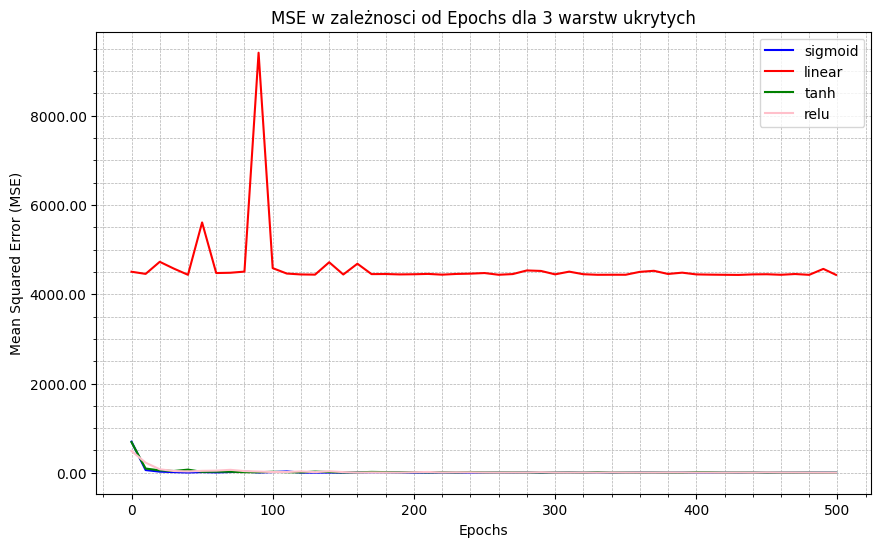

In [191]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla 3 warstw ukrytych')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid, mse_linear, mse_tanh, mse_relu]
labels = ['sigmoid', 'linear', 'tanh', 'relu']
colors = ['blue', 'red', 'green', 'pink']

plot_mse(datasets, labels, colors)

'''mse_sigmoid = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)
mse 2.2039491592926326'''

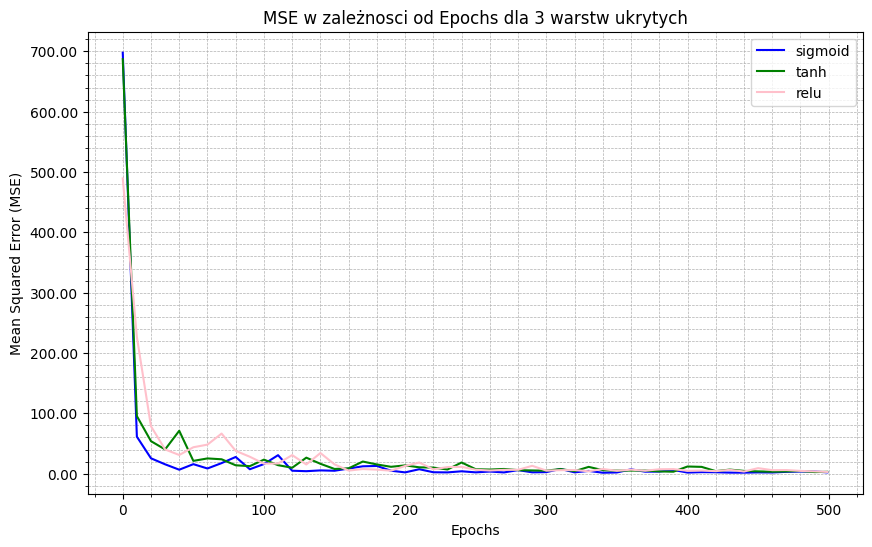

In [192]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla 3 warstw ukrytych')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid, mse_tanh, mse_relu]
labels = ['sigmoid',  'tanh', 'relu']
colors = ['blue', 'green', 'pink']

plot_mse(datasets, labels, colors)

'''mse_sigmoid = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)
mse 2.2039491592926326'''


## 2 warstwy ukryte

In [193]:
mlp_square_1_5 = MLP([1, 64, 32, 1] , activation_function=sigmoid, activation_function_derivative= sigmoid_derivative)

[array([[ 1.06230199],
       [ 0.40243632],
       [ 0.58847208],
       [-0.37287259],
       [-0.1075983 ],
       [-0.84453113],
       [ 0.60300007],
       [ 0.20271232],
       [-0.2035053 ],
       [-1.08446115],
       [-0.82105091],
       [-0.43643498],
       [-1.8820656 ],
       [ 1.75084621],
       [ 0.39531062],
       [-1.77857609],
       [ 0.52328774],
       [ 1.03916045],
       [-1.16258772],
       [ 0.848638  ],
       [-1.11913954],
       [-1.71823794],
       [-0.74567064],
       [-0.21746757],
       [ 0.51548306],
       [-0.33648303],
       [ 1.90887898],
       [-0.21490078],
       [ 1.30422688],
       [-0.6367284 ],
       [-0.35243543],
       [-1.06108959],
       [-0.68788789],
       [-0.49655016],
       [-1.42105977],
       [ 0.49242348],
       [ 0.7076016 ],
       [ 0.63584767],
       [-0.14878931],
       [ 0.79197526],
       [-1.12644995],
       [-0.26580703],
       [-0.05885123],
       [ 0.44786932],
       [-0.69361187],
       [-

In [194]:
mse_sigmoid_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 817.0344237721712
Epoch 10, MSE: 101.84595579622986
Epoch 20, MSE: 88.77969101416666
Epoch 30, MSE: 42.38692669294385
Epoch 40, MSE: 30.42691047823906
Epoch 50, MSE: 10.530484907843224
Epoch 60, MSE: 10.804487542539828
Epoch 70, MSE: 7.982453178213015
Epoch 80, MSE: 31.652220412065304
Epoch 90, MSE: 12.145330358437839
Epoch 100, MSE: 11.087473044610045
Epoch 110, MSE: 22.717153862233623
Epoch 120, MSE: 7.787457979052432
Epoch 130, MSE: 5.265370843670763
Epoch 140, MSE: 18.64312657048835
Epoch 150, MSE: 20.662660311783217
Epoch 160, MSE: 8.021874565694105
Epoch 170, MSE: 11.237043009543727
Epoch 180, MSE: 5.324764744129864
Epoch 190, MSE: 22.136787511096014
Epoch 200, MSE: 13.397377167136511
Epoch 210, MSE: 5.1572223108913855
Epoch 220, MSE: 4.428016780667581
Epoch 230, MSE: 4.367006296033389
Epoch 240, MSE: 4.133302119501959
Epoch 250, MSE: 4.532342861664127
Epoch 260, MSE: 9.675158306661901
Epoch 270, MSE: 8.977973502202047
Epoch 280, MSE: 6.636816620096917
Epoch 290, MS

In [195]:
mlp_square_1_5 = MLP([1, 64, 32, 1] , activation_function=linear, activation_function_derivative= linear_derivative)

[array([[-0.83037681],
       [-0.07853945],
       [ 1.52075512],
       [ 0.50726921],
       [ 1.60377414],
       [-0.18546883],
       [-0.12641181],
       [ 0.87850121],
       [-0.57968524],
       [-0.80030606],
       [-0.34419939],
       [-0.03282528],
       [-1.93594702],
       [ 1.17079206],
       [-0.13103508],
       [-0.13936149],
       [-0.24492959],
       [ 0.02863056],
       [-1.42801213],
       [-2.22179267],
       [ 2.30933439],
       [-1.27504004],
       [ 0.48507773],
       [ 0.54186388],
       [ 2.76192715],
       [-1.77698043],
       [-1.49101391],
       [ 0.57403237],
       [-0.68377511],
       [-0.07340121],
       [-0.3298099 ],
       [ 0.2270062 ],
       [ 0.94024206],
       [-1.09452438],
       [-0.83763789],
       [-0.80369191],
       [ 0.57965195],
       [ 0.28005805],
       [ 1.45963486],
       [-1.59939984],
       [-0.69776031],
       [ 0.73196262],
       [-0.58615378],
       [ 0.40797779],
       [ 0.0786982 ],
       [ 

In [196]:
mse_linear_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 4625.697115529759
Epoch 10, MSE: 4983.9591635072975
Epoch 20, MSE: 4503.071267065199
Epoch 30, MSE: 4601.582688051345
Epoch 40, MSE: 4437.317012994879
Epoch 50, MSE: 7933.008146468934
Epoch 60, MSE: 4437.106490877899
Epoch 70, MSE: 4464.840478461275
Epoch 80, MSE: 4569.781736777801
Epoch 90, MSE: 4443.946035786923
Epoch 100, MSE: 4450.840053557733
Epoch 110, MSE: 4594.745157135386
Epoch 120, MSE: 4434.521401464187
Epoch 130, MSE: 4462.2557955596385
Epoch 140, MSE: 4599.282929095678
Epoch 150, MSE: 4464.938791298852
Epoch 160, MSE: 4441.258736377443
Epoch 170, MSE: 4466.405907742301
Epoch 180, MSE: 4564.350663717648
Epoch 190, MSE: 4440.137086491078
Epoch 200, MSE: 4444.394737181492
Epoch 210, MSE: 4442.022689323148
Epoch 220, MSE: 4468.316287396667
Epoch 230, MSE: 4436.722106054393
Epoch 240, MSE: 4502.750594330242
Epoch 250, MSE: 4484.54968043172
Epoch 260, MSE: 4434.7468357668595
Epoch 270, MSE: 4463.7557960817485
Epoch 280, MSE: 4438.780403637401
Epoch 290, MSE: 4436.0

In [197]:
mlp_square_1_5 = MLP([1, 64, 32, 1] , activation_function=tanh, activation_function_derivative= tanh_derivative)

[array([[ 1.04816976],
       [ 1.56872557],
       [ 0.71353041],
       [-0.28095302],
       [-0.42157192],
       [-0.3179272 ],
       [ 0.73719167],
       [ 0.03629866],
       [ 0.15926415],
       [-1.89352125],
       [-0.56714354],
       [ 0.29315312],
       [ 0.60856268],
       [ 0.31639097],
       [-1.16060622],
       [-0.01250946],
       [ 1.41878191],
       [ 0.50005142],
       [-1.70531781],
       [-1.474806  ],
       [-1.6121216 ],
       [ 0.98666702],
       [ 0.14712006],
       [ 1.73865744],
       [ 0.44056698],
       [ 0.73916563],
       [ 0.17739875],
       [ 0.00583919],
       [-1.86888225],
       [-0.68176389],
       [-1.08453296],
       [-1.00297852],
       [ 1.53169908],
       [ 0.46300397],
       [ 0.40057776],
       [ 0.06612551],
       [-1.37332931],
       [ 0.0557    ],
       [ 0.08598267],
       [ 0.23619155],
       [-0.07374697],
       [-1.15112377],
       [-0.0996089 ],
       [ 0.72791204],
       [ 0.727608  ],
       [ 

In [198]:
mse_tanh_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 170.2177198161223
Epoch 10, MSE: 123.50981381990053
Epoch 20, MSE: 31.46751437822697
Epoch 30, MSE: 107.00489044800351
Epoch 40, MSE: 160.78959368347464
Epoch 50, MSE: 52.6325121329044
Epoch 60, MSE: 30.380067174839805
Epoch 70, MSE: 24.65679823584662
Epoch 80, MSE: 29.43110701261974
Epoch 90, MSE: 45.969340450623754
Epoch 100, MSE: 11.358546507654172
Epoch 110, MSE: 14.546570434229563
Epoch 120, MSE: 31.23179087020354
Epoch 130, MSE: 11.207465453858225
Epoch 140, MSE: 44.80416639538805
Epoch 150, MSE: 22.50689476508891
Epoch 160, MSE: 16.21093444726198
Epoch 170, MSE: 39.97138223440865
Epoch 180, MSE: 20.490967792946226
Epoch 190, MSE: 17.017417197634234
Epoch 200, MSE: 40.68541279000965
Epoch 210, MSE: 14.184385594751054
Epoch 220, MSE: 7.523710280528008
Epoch 230, MSE: 12.301613431682474
Epoch 240, MSE: 11.18163161332246
Epoch 250, MSE: 9.26181493385716
Epoch 260, MSE: 20.164623837132645
Epoch 270, MSE: 23.30588385109641
Epoch 280, MSE: 24.879994060420923
Epoch 290, MS

In [199]:
mlp_square_1_5 = MLP([1, 64, 32, 1] , activation_function=relu, activation_function_derivative= relu_derivative)

[array([[ 0.9033776 ],
       [ 0.3021585 ],
       [-0.59964325],
       [-0.21538771],
       [-0.4689014 ],
       [-1.47097322],
       [ 0.21626706],
       [-1.2670231 ],
       [ 0.62017775],
       [-1.62008177],
       [-1.56657272],
       [ 0.16099266],
       [-0.58342338],
       [ 0.51627753],
       [-0.84371358],
       [-0.02803843],
       [ 0.03600243],
       [-1.25223229],
       [-0.78631845],
       [ 0.19019496],
       [ 0.58621149],
       [-1.12228188],
       [-0.61680573],
       [ 1.8066929 ],
       [ 0.81083575],
       [-0.19791338],
       [ 0.69011612],
       [-0.35951459],
       [-0.50283101],
       [-1.60197476],
       [ 1.17362863],
       [-0.32071655],
       [-1.08594805],
       [ 3.0382606 ],
       [-0.1873415 ],
       [ 1.18913578],
       [ 2.13954244],
       [ 0.94397865],
       [ 0.06796584],
       [-0.82987647],
       [ 0.06451821],
       [-0.54312495],
       [-0.79798451],
       [-1.48274989],
       [ 0.93717177],
       [-

In [200]:
mse_relu_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 330.68564839098093
Epoch 10, MSE: 51.430606626737166
Epoch 20, MSE: 82.8057549228655
Epoch 30, MSE: 23.31429335482434
Epoch 40, MSE: 18.304353720158847
Epoch 50, MSE: 32.48713120477113
Epoch 60, MSE: 12.219889726926814
Epoch 70, MSE: 21.745226028810386
Epoch 80, MSE: 14.259306583603172
Epoch 90, MSE: 16.687959194992946
Epoch 100, MSE: 31.74850958312097
Epoch 110, MSE: 21.627810235701222
Epoch 120, MSE: 15.943645247506053
Epoch 130, MSE: 12.29204154692693
Epoch 140, MSE: 11.49910701567726
Epoch 150, MSE: 7.324974626963675
Epoch 160, MSE: 12.122699788404654
Epoch 170, MSE: 10.493324866899181
Epoch 180, MSE: 6.870428152834126
Epoch 190, MSE: 11.80468804675904
Epoch 200, MSE: 8.544863223080334
Epoch 210, MSE: 8.61648690711845
Epoch 220, MSE: 13.496765678007655
Epoch 230, MSE: 14.025436103327255
Epoch 240, MSE: 8.776515866733789
Epoch 250, MSE: 7.583063991662181
Epoch 260, MSE: 14.265813863778455
Epoch 270, MSE: 11.155994466766057
Epoch 280, MSE: 5.664383901338357
Epoch 290, M

In [201]:
mse_sigmoid_2 = list_to_dataframe(mse_sigmoid_2)
mse_linear_2 = list_to_dataframe(mse_linear_2)
mse_tanh_2 = list_to_dataframe(mse_tanh_2)
mse_relu_2 = list_to_dataframe(mse_relu_2)

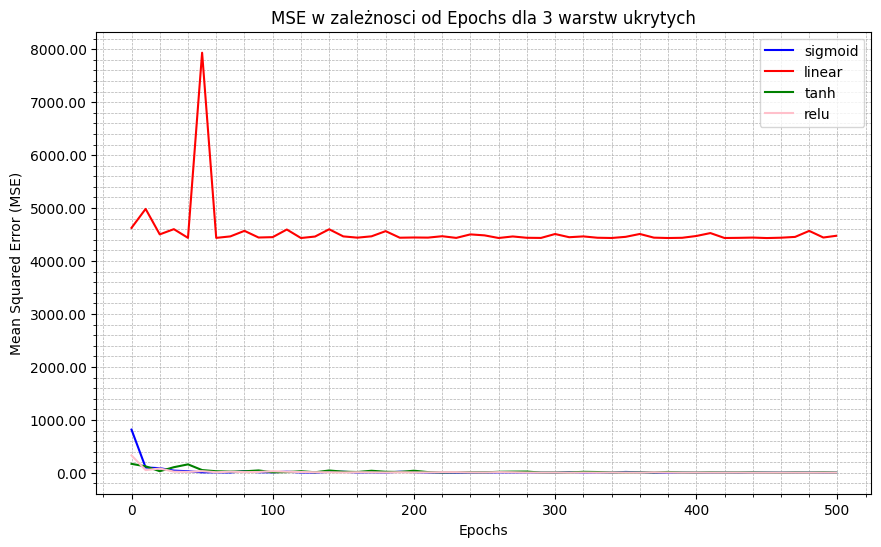

In [202]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid_2, mse_linear_2, mse_tanh_2, mse_relu_2]
labels = ['sigmoid', 'linear', 'tanh', 'relu']
colors = ['blue', 'red', 'green', 'pink']

plot_mse(datasets, labels, colors)

'''
mse_relu_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)
mse 3.334245858731005'''


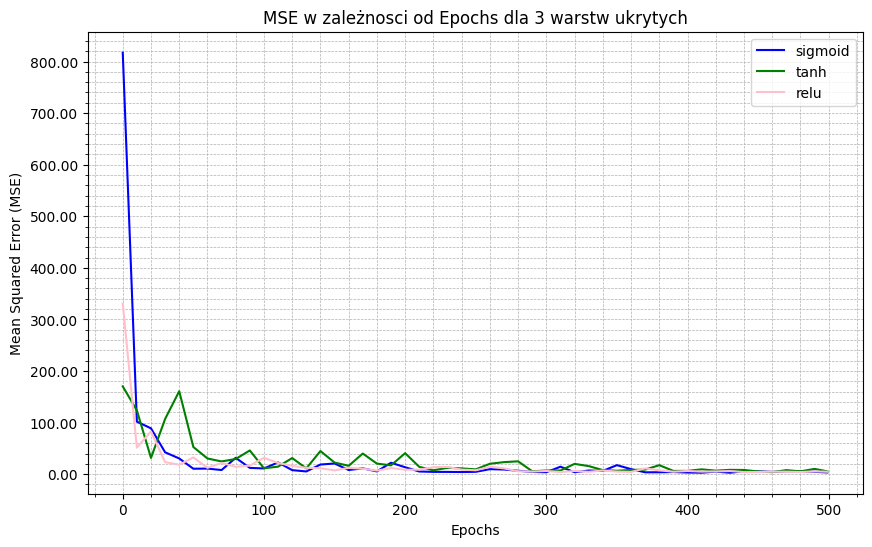

In [203]:

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid_2, mse_tanh_2, mse_relu_2]
labels = ['sigmoid',  'tanh', 'relu']
colors = ['blue', 'green', 'pink']

plot_mse(datasets, labels, colors)

'''
mse_relu_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)
mse 3.334245858731005'''


## 1 warstwa ukryta

In [204]:
mlp_square_1_5 = MLP([1, 64, 1] , activation_function=sigmoid, activation_function_derivative= sigmoid_derivative)

[array([[-0.42661277],
       [-1.59375725],
       [ 0.07985009],
       [ 0.17263367],
       [-0.70728974],
       [ 0.11004089],
       [ 0.15660256],
       [ 0.50667706],
       [-1.22732901],
       [ 0.25221591],
       [-0.78848339],
       [ 0.67270848],
       [ 1.19527783],
       [-0.44055182],
       [-1.34225453],
       [ 0.86296174],
       [-0.54015538],
       [ 0.3425432 ],
       [-0.12031386],
       [ 0.10814388],
       [ 0.36193681],
       [ 0.30557145],
       [ 0.91692231],
       [ 0.0117854 ],
       [ 0.13615035],
       [ 0.66653605],
       [-1.64317599],
       [-0.84440251],
       [ 0.00626117],
       [ 0.91510641],
       [ 0.30093539],
       [ 1.18307153],
       [-0.294665  ],
       [ 1.88575409],
       [-1.94462222],
       [-1.34663341],
       [ 1.50176655],
       [-0.15038216],
       [ 0.09716466],
       [-0.4385007 ],
       [-0.10044182],
       [-1.09866675],
       [ 0.92962549],
       [ 0.02389611],
       [ 1.21774425],
       [ 

In [205]:
mse_sigmoid_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 2528.4406199245786
Epoch 10, MSE: 788.7734006355025
Epoch 20, MSE: 607.436920886482
Epoch 30, MSE: 1014.9734385175518
Epoch 40, MSE: 628.8778352600981
Epoch 50, MSE: 445.81863128597564
Epoch 60, MSE: 434.7843279049877
Epoch 70, MSE: 335.5883731746712
Epoch 80, MSE: 337.6914512139893
Epoch 90, MSE: 366.4015654292925
Epoch 100, MSE: 345.8104324640364
Epoch 110, MSE: 393.3506853940123
Epoch 120, MSE: 364.3837151863308
Epoch 130, MSE: 363.5494669983825
Epoch 140, MSE: 339.7876001422276
Epoch 150, MSE: 319.05043934591697
Epoch 160, MSE: 321.64716241300937
Epoch 170, MSE: 330.3340494963069
Epoch 180, MSE: 332.2083332582568
Epoch 190, MSE: 408.1491831089769
Epoch 200, MSE: 327.9206912039897
Epoch 210, MSE: 338.29850651806
Epoch 220, MSE: 323.22289658558066
Epoch 230, MSE: 338.9684232958363
Epoch 240, MSE: 319.14287324059603
Epoch 250, MSE: 329.04952178836646
Epoch 260, MSE: 345.97300760884525
Epoch 270, MSE: 338.24081810238397
Epoch 280, MSE: 329.7900364119068
Epoch 290, MSE: 31

In [206]:
mlp_square_1_5 = MLP([1, 64, 1] , activation_function=linear, activation_function_derivative= linear_derivative)

[array([[ 0.36474503],
       [-1.5696359 ],
       [ 0.0931508 ],
       [-0.48276207],
       [-1.61763356],
       [-1.51329528],
       [-0.59196171],
       [ 1.45817498],
       [-1.56863188],
       [ 1.32801048],
       [ 0.62420081],
       [-1.61792309],
       [-0.3091295 ],
       [ 0.18810947],
       [-0.50302098],
       [-1.15746719],
       [-0.28261999],
       [ 1.11162113],
       [ 3.72653075],
       [-0.21914218],
       [-1.04268392],
       [-0.66356886],
       [ 0.73941202],
       [-0.34260001],
       [ 0.30336741],
       [ 1.14322062],
       [ 1.7196488 ],
       [ 0.46674541],
       [ 0.71840249],
       [-0.66592804],
       [-1.03431837],
       [-0.34390107],
       [ 1.06040803],
       [-0.65087792],
       [ 1.89419899],
       [-1.85842731],
       [-0.16541603],
       [-0.36769896],
       [ 1.79983418],
       [ 0.02667986],
       [ 1.4620475 ],
       [-2.18058827],
       [-1.02008985],
       [ 1.63337406],
       [ 1.46293385],
       [-

In [207]:
mse_linear_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 5006.484482119918
Epoch 10, MSE: 4531.050964580499
Epoch 20, MSE: 5215.478686019272
Epoch 30, MSE: 4683.9149651576
Epoch 40, MSE: 4596.768891318784
Epoch 50, MSE: 4461.442359988082
Epoch 60, MSE: 4806.008168560237
Epoch 70, MSE: 4514.15514661151
Epoch 80, MSE: 4442.3379841655415
Epoch 90, MSE: 4502.873548631559
Epoch 100, MSE: 4585.095972084088
Epoch 110, MSE: 4480.62276713266
Epoch 120, MSE: 4442.510037587308
Epoch 130, MSE: 4439.837913276591
Epoch 140, MSE: 4476.860666835819
Epoch 150, MSE: 4437.910269852089
Epoch 160, MSE: 4517.219023361929
Epoch 170, MSE: 4530.212499690489
Epoch 180, MSE: 4503.105820934743
Epoch 190, MSE: 4484.336983492775
Epoch 200, MSE: 4474.293937071932
Epoch 210, MSE: 4434.437341442423
Epoch 220, MSE: 4434.299174117096
Epoch 230, MSE: 4446.623588900723
Epoch 240, MSE: 4441.843298918299
Epoch 250, MSE: 4439.416038584186
Epoch 260, MSE: 4468.957047004386
Epoch 270, MSE: 4434.582529450035
Epoch 280, MSE: 4498.713136515172
Epoch 290, MSE: 4434.4124790

In [208]:
mlp_square_1_5 = MLP([1, 64, 1] , activation_function=tanh, activation_function_derivative= tanh_derivative)

[array([[-0.63422421],
       [ 1.02669713],
       [ 0.56983585],
       [-1.20932039],
       [ 0.44605537],
       [ 1.7103442 ],
       [-1.79421207],
       [-1.34895332],
       [-1.74608236],
       [ 0.95500897],
       [-0.97246695],
       [-0.06671395],
       [-0.01807596],
       [ 0.73162708],
       [-1.31026973],
       [-0.19821671],
       [ 0.83733535],
       [ 0.57793199],
       [ 0.15430866],
       [-0.34483559],
       [-0.02965106],
       [-0.35617482],
       [ 0.72060175],
       [ 0.19286206],
       [ 0.6313361 ],
       [ 1.61310354],
       [-0.88780859],
       [ 0.12514288],
       [ 1.46132547],
       [ 0.32321195],
       [-2.19016207],
       [ 0.56342566],
       [-0.40108685],
       [-0.69574679],
       [ 1.39285174],
       [ 2.17190763],
       [ 1.21295874],
       [ 1.99872936],
       [-1.45052233],
       [ 2.52610749],
       [-1.63560118],
       [-0.27343975],
       [-0.23739453],
       [ 0.18116949],
       [-0.35893876],
       [-

In [209]:
mse_tanh_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 880.78451511437
Epoch 10, MSE: 528.2457930667102
Epoch 20, MSE: 330.40835459617125
Epoch 30, MSE: 336.6262895796698
Epoch 40, MSE: 394.2852274986772
Epoch 50, MSE: 301.5208003918749
Epoch 60, MSE: 276.35362468321165
Epoch 70, MSE: 349.27425646426326
Epoch 80, MSE: 272.6010634644287
Epoch 90, MSE: 289.0504593055529
Epoch 100, MSE: 279.6034106899187
Epoch 110, MSE: 370.8904706156678
Epoch 120, MSE: 231.2768214894209
Epoch 130, MSE: 300.26960983891246
Epoch 140, MSE: 238.44534568212356
Epoch 150, MSE: 293.0622203580028
Epoch 160, MSE: 238.19501173312065
Epoch 170, MSE: 209.64299286365662
Epoch 180, MSE: 354.2735248704466
Epoch 190, MSE: 236.96634660177003
Epoch 200, MSE: 231.6324327477243
Epoch 210, MSE: 366.6961474899753
Epoch 220, MSE: 215.2361328358242
Epoch 230, MSE: 214.71655291947675
Epoch 240, MSE: 207.76639224493584
Epoch 250, MSE: 206.39497004184435
Epoch 260, MSE: 203.14504560832498
Epoch 270, MSE: 205.57749566327414
Epoch 280, MSE: 217.97011629302455
Epoch 290, MS

In [210]:
mlp_square_1_5 = MLP([1, 64, 1] , activation_function=relu, activation_function_derivative= relu_derivative)

[array([[-0.88640204],
       [-0.88283464],
       [-0.42143017],
       [ 2.05568043],
       [ 0.24974438],
       [ 0.23448338],
       [-1.46098387],
       [-0.56078689],
       [-0.88784626],
       [-1.7064043 ],
       [-0.19168293],
       [-1.46369072],
       [-1.59896508],
       [-2.65467686],
       [ 0.51534885],
       [ 0.96623797],
       [ 0.58246671],
       [-0.42882417],
       [-0.94699727],
       [ 1.15103885],
       [ 0.95571483],
       [-0.61840552],
       [ 1.36045507],
       [ 1.39550164],
       [-0.63178275],
       [-0.32441189],
       [ 0.90241302],
       [ 0.80389101],
       [ 0.73770427],
       [ 0.07940267],
       [ 0.01033395],
       [-1.00289813],
       [ 1.04213315],
       [-0.387485  ],
       [ 2.04300536],
       [-1.20310507],
       [ 2.22739595],
       [-0.67440168],
       [-2.15379771],
       [ 0.99082373],
       [ 0.04625072],
       [-1.42441028],
       [-0.24093646],
       [ 0.07740996],
       [-1.12543224],
       [-

In [211]:
mse_relu_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 1453.2653247212018
Epoch 10, MSE: 442.1055566659945
Epoch 20, MSE: 1018.3799929562039
Epoch 30, MSE: 330.30782009777255
Epoch 40, MSE: 304.5590141090674
Epoch 50, MSE: 297.58981545549324
Epoch 60, MSE: 247.08281693213172
Epoch 70, MSE: 576.0155472129867
Epoch 80, MSE: 188.03334953638273
Epoch 90, MSE: 153.30637417586775
Epoch 100, MSE: 219.48701859167252
Epoch 110, MSE: 253.72990764632797
Epoch 120, MSE: 232.29936002478343
Epoch 130, MSE: 458.39226146739554
Epoch 140, MSE: 228.8479533869667
Epoch 150, MSE: 167.41558779575547
Epoch 160, MSE: 162.6446652030548
Epoch 170, MSE: 558.3269413578993
Epoch 180, MSE: 139.95598108218604
Epoch 190, MSE: 143.19236852186657
Epoch 200, MSE: 159.6850119570298
Epoch 210, MSE: 122.82291882683023
Epoch 220, MSE: 157.68478456735298
Epoch 230, MSE: 128.24067527185446
Epoch 240, MSE: 154.98082754601842
Epoch 250, MSE: 119.34582955992062
Epoch 260, MSE: 107.22588977482242
Epoch 270, MSE: 202.64751765780488
Epoch 280, MSE: 41.97649533865506
Epoc

In [213]:
mse_sigmoid_3 = list_to_dataframe(mse_sigmoid_3)
mse_linear_3 = list_to_dataframe(mse_linear_3)
mse_tanh_3 = list_to_dataframe(mse_tanh_3)
mse_relu_3 = list_to_dataframe(mse_relu_3)

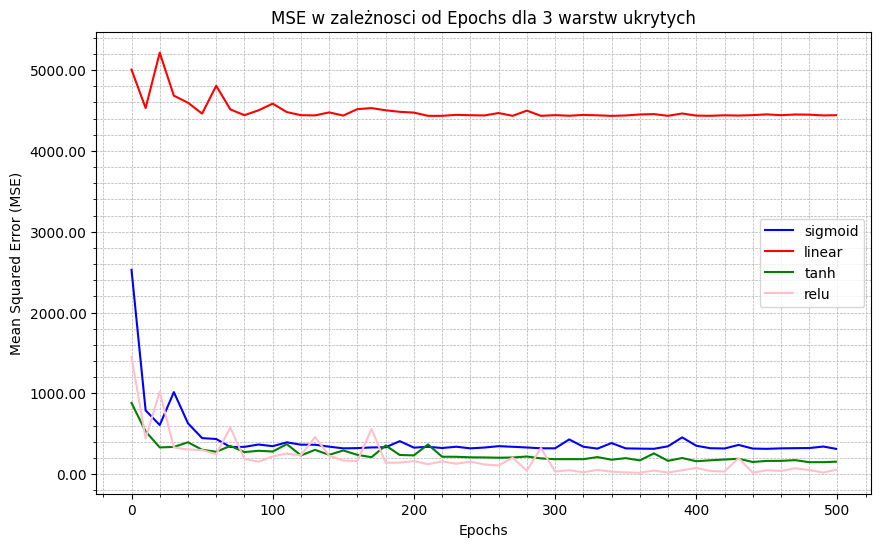

In [214]:

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid_3, mse_linear_3, mse_tanh_3, mse_relu_3]
labels = ['sigmoid', 'linear', 'tanh', 'relu']
colors = ['blue', 'red', 'green', 'pink']

plot_mse(datasets, labels, colors)

'''mse_sigmoid_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)
mse 19.54497591094832
'''


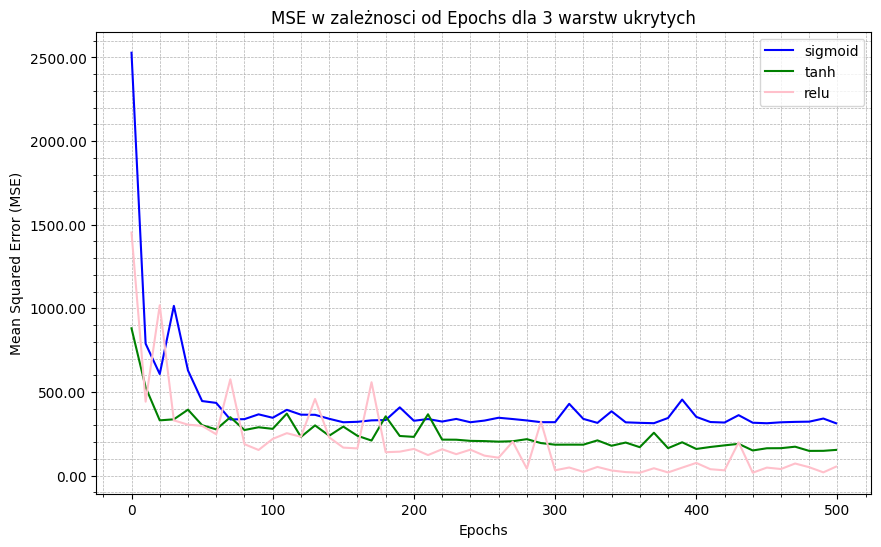

In [215]:

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid_3, mse_tanh_3, mse_relu_3]
labels = ['sigmoid',  'tanh', 'relu']
colors = ['blue', 'green', 'pink']

plot_mse(datasets, labels, colors)

'''mse_sigmoid_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)
mse 19.54497591094832
'''


#### testing

In [65]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [67]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_multimodal_large[i])
mse_score = mse(predictions, y_test_multimodal_large)

print(f"MSE Score: {mse_score}")

predicted value:  [-97.52083727] actual value:  [-98.2081664]
predicted value:  [-54.25551153] actual value:  [-55.28389066]
predicted value:  [99.65196547] actual value:  [100.29999676]
predicted value:  [4.09228165] actual value:  [2.7206294]
predicted value:  [-73.86446255] actual value:  [-75.99163605]
predicted value:  [37.69087725] actual value:  [36.4875116]
predicted value:  [28.26103944] actual value:  [32.9071937]
predicted value:  [51.89040415] actual value:  [54.59378752]
predicted value:  [69.45158391] actual value:  [75.88595471]
predicted value:  [16.72811997] actual value:  [15.93020098]
predicted value:  [32.52955311] actual value:  [36.41048972]
predicted value:  [100.20211309] actual value:  [100.17958374]
predicted value:  [-95.59186227] actual value:  [-96.19000955]
predicted value:  [99.29064866] actual value:  [100.29859577]
predicted value:  [-63.8971626] actual value:  [-64.55778832]
predicted value:  [69.35791887] actual value:  [73.08482928]
predicted value: 

## steps-large dataset

In [33]:
scaler_X = DataScaler(method="standardization")
scaler_y = DataScaler(method="standardization")


In [34]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_steps_large)
y_train_scaled = scaler_y.fit_transform(y_train_steps_large)


In [35]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_steps_large)
y_test_scaled = scaler_y.transform(y_test_steps_large)

In [36]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_steps_large, y_train_steps_large)]

In [37]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [41]:
mlp5 = MLP([1, 64, 32, 1] , activation_function=sigmoid, activation_function_derivative= sigmoid_derivative)

[array([[ 0.29066296],
       [-1.81315664],
       [-0.02065545],
       [ 2.0381146 ],
       [-1.85118435],
       [ 0.30831102],
       [ 0.37682723],
       [-1.23409198],
       [-0.23899994],
       [-0.06669953],
       [-0.29676497],
       [-0.55549398],
       [ 0.16225242],
       [ 0.89562433],
       [ 0.23375582],
       [ 0.25177666],
       [ 0.00575501],
       [-1.26105473],
       [ 1.35462399],
       [-1.27409752],
       [ 0.07281527],
       [-0.50360212],
       [-1.15288742],
       [ 0.0934778 ],
       [-1.12097909],
       [ 0.17781388],
       [ 0.68610384],
       [ 0.53910171],
       [-1.25034353],
       [-0.36032694],
       [-0.16170809],
       [-0.5045256 ],
       [ 0.09338843],
       [-0.23722481],
       [ 1.35824285],
       [-0.67741987],
       [-2.05222011],
       [ 0.9642252 ],
       [ 0.10281455],
       [-0.61048355],
       [ 0.77188643],
       [ 0.96540988],
       [-1.6800272 ],
       [-0.15239023],
       [-2.55952073],
       [-

In [42]:
mse1 = mlp5.train(
    training_data_scaled, epochs=500, learning_rate=0.01, batch_size=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_steps_large, y_val = y_test_steps_large, scaler_y = scaler_y,
    mse_limit = 3, visual_interval = 10
)

Epoch 0, MSE: 281.7509553356159
Epoch 10, MSE: 88.47623197793399
Epoch 20, MSE: 44.55089324977555
Epoch 30, MSE: 50.37375246736075
Epoch 40, MSE: 27.880069107282054
Epoch 50, MSE: 36.46503062532205
Epoch 60, MSE: 39.5465724628765
Epoch 70, MSE: 46.00713915541193
Epoch 80, MSE: 94.65297368445273
Epoch 90, MSE: 25.932807680837215
Epoch 100, MSE: 18.1885133234631
Epoch 110, MSE: 36.81394848874393
Epoch 120, MSE: 23.218694280591865
Epoch 130, MSE: 33.53721934547982
Epoch 140, MSE: 25.92235196778706
Epoch 150, MSE: 21.49670163098614
Epoch 160, MSE: 32.00507995655728
Epoch 170, MSE: 58.101882181368914
Epoch 180, MSE: 17.760106861348437
Epoch 190, MSE: 57.62749004349154
Epoch 200, MSE: 45.93076707861371
Epoch 210, MSE: 20.12549965752323
Epoch 220, MSE: 40.18651626985822
Epoch 230, MSE: 21.697145073464156
Epoch 240, MSE: 50.211389502292704
Epoch 250, MSE: 35.96453147621476
Epoch 260, MSE: 36.712305580010415
Epoch 270, MSE: 22.420620824199606
Epoch 280, MSE: 35.90877949384905
Epoch 290, MSE: 17

In [43]:
mlp6 = MLP([1, 64, 32, 32, 1] , activation_function=sigmoid, activation_function_derivative= sigmoid_derivative)

[array([[ 2.48563669e-01],
       [ 1.27207641e+00],
       [-1.15629408e-01],
       [-8.18033811e-01],
       [ 1.44373928e+00],
       [-1.27618576e+00],
       [-6.41205822e-01],
       [-1.05838377e-01],
       [-1.66968671e-01],
       [-1.30485319e+00],
       [-4.56802754e-01],
       [-1.46838115e-01],
       [-8.74888880e-01],
       [-3.69284630e-01],
       [ 8.63687598e-01],
       [-1.04811001e+00],
       [-3.36948626e-01],
       [-1.49327151e+00],
       [-7.81819341e-01],
       [-1.07631627e+00],
       [ 1.73320277e+00],
       [ 6.93911390e-01],
       [ 6.58436892e-01],
       [ 1.32784014e+00],
       [-1.44299706e-01],
       [ 7.35231676e-01],
       [ 7.95397286e-01],
       [ 1.57382212e-03],
       [ 1.38268282e+00],
       [-2.92920613e-01],
       [ 5.30209236e-01],
       [-1.22916721e+00],
       [ 1.72318497e+00],
       [ 1.19601514e+00],
       [-5.42160609e-01],
       [-7.19466495e-02],
       [ 4.16370074e-01],
       [ 2.64238498e-01],
       [-9.

In [44]:
mse2 = mlp5.train(
    training_data_scaled, epochs=500, learning_rate=0.01, batch_size=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_steps_large, y_val = y_test_steps_large, scaler_y = scaler_y,
    mse_limit = 3, visual_interval = 10
)

Epoch 0, MSE: 26.342627614522055
Epoch 10, MSE: 28.857218939330835
Epoch 20, MSE: 28.13345178873499
Epoch 30, MSE: 15.79173471510824
Epoch 40, MSE: 14.582735016617745
Epoch 50, MSE: 76.18395197200091
Epoch 60, MSE: 17.358803825258292
Epoch 70, MSE: 24.64068154005545
Epoch 80, MSE: 21.536893380866324
Epoch 90, MSE: 17.306885504938833
Epoch 100, MSE: 18.73875820448379
Epoch 110, MSE: 21.19792044133613
Epoch 120, MSE: 25.86750122877259
Epoch 130, MSE: 7.866588113420535
Epoch 140, MSE: 26.06104379290302
Epoch 150, MSE: 44.90955795682502
Epoch 160, MSE: 15.269597179960968
Epoch 170, MSE: 42.57232177073872
Epoch 180, MSE: 19.469901796495904
Epoch 190, MSE: 30.187442219010748
Epoch 200, MSE: 8.628056960717736
Epoch 210, MSE: 47.82070683106115
Epoch 220, MSE: 12.575642660901732
Epoch 230, MSE: 53.157835021358856
Epoch 240, MSE: 21.465929615902386
Epoch 250, MSE: 9.493765268664612
Epoch 260, MSE: 13.986302192637787
Epoch 270, MSE: 14.503875360761889
Epoch 280, MSE: 10.810619002406348
Epoch 290,

In [46]:
mse1 = list_to_dataframe(mse1)
mse2 = list_to_dataframe(mse2)

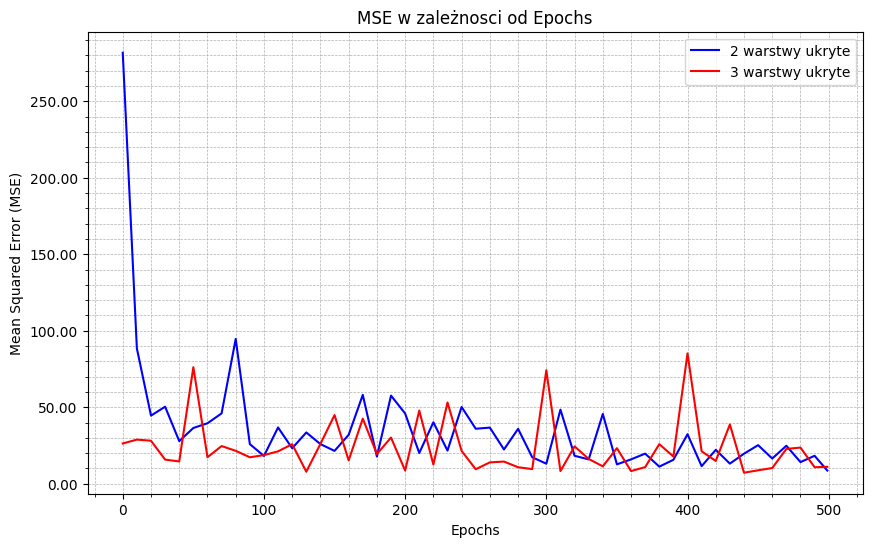

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse1, mse2]
labels = ['2 warstwy ukryte', '3 warstwy ukryte']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)
#8.635490801989514
#8.628056960717736